# **Title: Comparison of Data Mining and Natural Language Processing Techniques for Crash Analysis**

1.	**GRU_Word2Vec_Unbalanced** 
3.	**GRU_Word2Vec_Balanced_Pos**
4.	**LSTM_Word2Vec_Balanced**
5.	**LSTM_Word2Vec_Unbalanced**
6.	**LSTM_Word2Vec_Balanced_Pos**
7.	**SVM_CF_Unbalanced**
8.	**SVM_CF_Balanced_Pos**
9.	**LGR_CF Balanced**
10.	**Bigram NoisyOR**

**Bigram NoisyOR**



* Word2Vec=Pretrained GoogleNews-vectors-negative300
* Balanced= keep all the workzone crashes and pull same amount of non workzone crashes from random sampling
*Pos = keep only the sentances which has positive unigram onky from **Unigram- NoisyOR**















In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



# **Dependencies**



In [5]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding,LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import string
import nltk
import math
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import os

Using TensorFlow backend.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Load google word-embedding**


In [6]:
from gensim.models import KeyedVectors
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
word2vec_model = KeyedVectors.load_word2vec_format('/content/drive/My Drive/New/GoogleNews-vectors-negative300.bin', binary=True)

2020-06-15 22:29:29,160 : INFO : loading projection weights from /content/drive/My Drive/New/GoogleNews-vectors-negative300.bin
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-06-15 22:30:37,972 : INFO : loaded (3000000, 300) matrix from /content/drive/My Drive/New/GoogleNews-vectors-negative300.bin


# **Data porcessing**

Write a function to rpocess the data

In [0]:
def clean_doc(textlist):
    #list to store the clean data
    output=[]
    #read by narratives.Here,  A narrative is a string of multiple sentences.
    for doc in textlist:
        # make all lower case
        doc=doc.lower()
        # create temporary token
        tokens=doc.split()
        # remove all punctuation
        table=str.maketrans('','',string.punctuation)
        tokens=[w.translate(table) for w in tokens]
        # remove numeric values
        tokens1=[word for word in tokens if word.isalpha()]
        # remove stop words
        stop_words=set(stopwords.words('english'))
        tokens2=[w for w in tokens1 if not w in stop_words]
        # remove words which has <= 2 characters
        tokens3=' '.join([word for word in tokens2 if len(word)>=2]) 
        # return the clean sentance again 
        output.append(tokens3)
    return output

Call the data to process

> Trainning data 2017-2018 which includes reported WZ and NWZ. WZ=1 and NWZ=0.


1.   Delete all records that has null values in construction and narrative columns
2.   Format date field for data analysis





In [0]:
# Train and Test file name
trainFile='/content/drive/My Drive/New/Train_raw_data/TrainingDataSet_Balanced.csv' 
#testFile='/content/drive/My Drive/New/Train_raw_data/Random_200_Manual Review_WZ_NWZ_6_10.csv'  
testFile='/content/drive/My Drive/New/Train_raw_data/Selected_field2019 DT4000 crashes_expanded_with_narr.csv'    
# which is consisted of 2017-2018 WZ and NWZ (balanced data)
traindf=pd.read_csv(trainFile)
# drop null rows as it will results error in classifying algorithm.
traindf=traindf.dropna(subset=['CONSZONE','OFFRNARR'])


Clean the data and Prepare train and test data

In [51]:
######  Train data
# no need. you can use it for result analysis, or make query by data
'''traindf['CRSHDATE']=pd.to_datetime(traindf['CRSHDATE'])'''
# use only the narrative as train data and make it a list/arrary
x_train_text=traindf["OFFRNARR"].values
# print a narrative before data cleaning
print ("Before Data cleaning:\n", x_train_text[0])
#clean the data
x_train_text=clean_doc(x_train_text)
# print the clean data
print ("After Data cleaning:\n",x_train_text[0])
# it was y as conszone in the field. but here, this data has conszone (WZ) with Y=1, and Null=0=NWZ. It was done before calling it here.
y_train_text=traindf["CONSZONE"].values

######  Test data
#test data consists of 2019 dataset, for our case it is only NWZ part of 2019 
testdf=pd.read_csv(testFile,dtype={'CONSZONE': int,'OFFRNARR':str})
testdf=testdf[testdf.CONSZONE==0]
# drop null rows as it will results error in classifying algorithm.
testdf=testdf.dropna(subset=['CONSZONE','OFFRNARR'])
#testdf.to_csv('test2019.csv',index=None)
# do the same for test data
x_test_text=testdf["OFFRNARR"].values
x_test_text=clean_doc(x_test_text)
y_test_text=testdf["CONSZONE"].values
print(x_test_text)
# print number of narratives fro train and test
print (len(x_train_text),len(x_test_text))

Before Data cleaning:
 eb i at sth  s th st on ramp  squad arrived and found a two car pdo  operator of unit  stated that he was traveling east in the left lane and the vehicle in front of him stopped suddenly  operator of unit one stated i braked and my antilock brakes activated and i hit the car in front of me  operator of unit two stated that he was traveling east in the left lane on i and traffic in front of him came to a stop so he slowed down and the truck behind him hit him  upon investigation units one and two were traveling east on i just under the hwy  overpass  unit two slowed due to traffic congestion and unit one struck unit two in the rear  no witness  no tows

After Data cleaning:
 eb sth th st ramp squad arrived found two car pdo operator unit stated traveling east left lane vehicle front stopped suddenly operator unit one stated braked antilock brakes activated hit car front operator unit two stated traveling east left lane traffic front came stop slowed truck behind h

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# **Tokenization and word vectorization**

In [0]:
# Apply tokenizer on the train data only. it will create words/tokens from train data only. so any new words in test data will be converted into 0 and be used as padding value
%%time
tokenizer=Tokenizer(num_words=10)
tokenizer.fit_on_texts(x_train_text)
# create integer of tokens for the trainning data
x_train_tokens=tokenizer.texts_to_sequences(x_train_text)
# create integer of tokens for the testing data
x_test_tokens=tokenizer.texts_to_sequences(x_test_text)
print(x_test_text[0])
print(x_test_tokens[0],tokenizer.word_index)
del tokenizer.word_index['unit']
x_test_tokens=tokenizer.texts_to_sequences(x_test_text)
print(x_test_tokens[0],tokenizer.word_index)
print(tokenizer.num_words)


unit southbound sydney ave lost control motor vehicle stating accelerated test engine working driver corrected steering spun clockwise direction entering west ditch hit drivewayshoulder overturned unit driver stated going unit incurred disabling damages
[1, 3, 5, 1, 5, 4, 1] {'unit': 1, 'lane': 2, 'vehicle': 3, 'stated': 4, 'driver': 5, 'traffic': 6, 'traveling': 7, 'struck': 8, 'left': 9, 'right': 10, 'operator': 11, 'front': 12, 'stop': 13, 'rear': 14, 'damage': 15, 'stopped': 16, 'side': 17, 'st': 18, 'turn': 19, 'crash': 20, 'due': 21, 'road': 22, 'behind': 23, 'one': 24, 'scene': 25, 'construction': 26, 'units': 27, 'car': 28, 'hit': 29, 'ave': 30, 'time': 31, 'th': 32, 'control': 33, 'intersection': 34, 'south': 35, 'north': 36, 'injuries': 37, 'northbound': 38, 'rd': 39, 'two': 40, 'came': 41, 'vehicles': 42, 'southbound': 43, 'roadway': 44, 'west': 45, 'onto': 46, 'nb': 47, 'causing': 48, 'street': 49, 'east': 50, 'sb': 51, 'upon': 52, 'light': 53, 'sign': 54, 'westbound': 55, 

Analyze the length of vector as well as Narrative length to decide the vector length

In [0]:
num_tokens=[len(tokens) for tokens in x_train_tokens]
num_tokens=np.array(num_tokens)
max_tokens=np.max(num_tokens)
print ("maximum Narrative length after data cleaning:",max_tokens)
max_tokens_3std = math.ceil(np.mean(num_tokens) + 3* np.std(num_tokens))
print ("average Narrative length at 3rd STD after data cleaning:", max_tokens_3std)


maximum Narrative length after data cleaning: 216
average Narrative length at 3rd STD after data cleaning: 154


Apply the 3rd STD value as the maximum narrative length.

In [0]:
# to apply fixed sequence length, pad with 0 at the beginning of sequence
pad='post'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens_3std,padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens_3std,padding=pad, truncating=pad)
#print(x_train_pad)
# next apply classification algorithm.

[[  60    7 1645 ...    0    0    0]
 [   1   21    7 ...    0    0    0]
 [   4    6   16 ...    0    0    0]
 ...
 [   1    9    2 ...    0    0    0]
 [   1    7  119 ...    0    0    0]
 [   1    7   53 ...    0    0    0]]


Write functions to apply word embedding. NUM_WORDS is the length of embedding vector. As we are using Google word-embeding, i chose a value of 300. Added 1 to store the dimensions for the words for which no pretrained word embeddings exist

In [0]:
num_words=62645 #len(tokenizer.word_index)+1
def getVector(str):
 if str in word2vec_model:
  return word2vec_model[str]
 else:
  return None;
def isInModel(str):
  return str in word2vec_model

embedding_size=300
embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i>=embedding_size:
        continue
    try:
        #print(word)
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embedding_size)

In [0]:
print (embedding_matrix.shape)

(62645, 300)


# **Develop the Deep Learning Model**


1.   num_words is the length of vocabulary
2.   List item



In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
import operator
def plot_roc(clf,model_name, y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr,label=model_name+': ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
   
def print_scores(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('F1 score: {:3f}'.format(f1_score(y_test, y_pred)))
    print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))

def vectorizebyCount(text, maxx_features):
    cv = CountVectorizer(max_features=maxx_features, stop_words='english')    
    countWord = cv.fit_transform(text)
    #index_value={i[1]:i[0] for i in cv.vocabulary_.items()}    
    #print (dict(sorted(index_value.items(), key=operator.itemgetter(0),reverse=True)))
    return cv,countWord

#optimizer = Adam(lr=1e-3)

def evaluation(model_name_list, x_trains,y_trains, x_tests,y_tests,test_split,test_file_df,TopFrequency):
    outputdf=test_file_df[['CRSHNMBR','CONSZONE','OFFRNARR']].copy()
    #for model_name in model_name_list:
     # outputdf[model_name]=np.NaN
    
    validation=int(y_test_text.shape[0]*.15) 
    tempList=[999]*validation   
    plt.figure(figsize=(10,5))
    
    for model_name in model_name_list: 
      
      cv,X = vectorizebyCount(x_trains,TopFrequency)
      tx=cv.transform(x_tests)
      x_train, x_test, y_train, y_test= X,tx,y_trains,y_tests
      #x_train, x_test, y_train, y_test= X,tx[validation:],y_trains,y_tests[validation:]
  
      if model_name=='LGR':  
          clf = LogisticRegression(random_state=0).fit(x_train, y_train)
          y_pred = clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          print("tn, fp, fn, tp",tn, fp, fn, tp)
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          plot_roc(clf,model_name, y_test,y_pred)          
          print (model_name+" done")
      elif model_name=='NB': 
          x_train,x_test=x_train.toarray(), x_test.toarray()
          clf= GaussianNB().fit(x_train, y_train)   
          y_pred=clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp) 
         # resultList.append([i[1] for i in pr])
          plot_roc(clf,model_name, y_test,y_pred)
          print (model_name+" done")
          
  
      elif model_name=='SVC': 
          clf= SVC(kernel='linear',probability=True).fit(x_train, y_train)   
          y_pred=clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp) 
         # resultList.append([i[1] for i in pr])
          plot_roc(clf,model_name, y_test,y_pred)          
          print (model_name+" done")
  
      elif model_name=='RF':
          clf= RandomForestClassifier().fit(x_train, y_train)          
          y_pred=clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp)          
         # resultList.append([i[1] for i in pr])
          plot_roc(clf,model_name, y_test,y_pred)
          
          print (model_name+" done")
      elif model_name=='Knn':
          clf= KNeighborsClassifier(n_neighbors=7).fit(x_train, y_train)
          y_pred=clf.predict_proba(x_test)
          y_pred=[i[1] for i in y_pred ] 
          tn, fp, fn, tp=confusion_matrix(y_test, clf.predict(x_test)).ravel()
          outputdf[model_name]=np.array(y_pred)
          #outputdf[model_name]=np.array(tempList+y_pred)
          print("tn, fp, fn, tp",tn, fp, fn, tp)    
          #resultList.append([i[1] for i in pr])
          #resultList.append(clf.predict(x_test))
          plot_roc(clf,model_name, y_test,y_pred)
          #skplt.metrics.plot_roc_curve(y_test,pr)
          #plt.show()
          
          print (model_name+" done")
      elif model_name=="GRU":
          tokenizer=Tokenizer(num_words=None)
          tokenizer.fit_on_texts(x_trains)
          x_train_tokens=tokenizer.texts_to_sequences(x_trains)
          x_test_tokens=tokenizer.texts_to_sequences(x_tests)
          num_tokens=[len(tokens) for tokens in x_train_tokens]
          num_tokens=np.array(num_tokens)
          max_tokens=np.max(num_tokens)
          max_tokens_3std = math.ceil(np.mean(num_tokens) + 3* np.std(num_tokens))
          pad='post'
          x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens_3std,padding=pad, truncating=pad)
          x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens_3std,padding=pad, truncating=pad)
          num_words=len(tokenizer.word_index)+1
          embedding_size=300
          embedding_matrix = np.zeros((num_words, embedding_size))
          for word, i in tokenizer.word_index.items():
              if i>=embedding_size:
                  continue
              try:
                  #print(word)
                  embedding_vector = word2vec_model[word]
                  embedding_matrix[i] = embedding_vector
              except KeyError:
                  embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),embedding_size)
          model=Sequential()
          model.add(Embedding(input_dim=num_words,output_dim=embedding_size,input_length=max_tokens_3std,name='layer_embedding',weights=[embedding_matrix],trainable=False))
          model.add(GRU(units=32, return_sequences=True))
          model.add(GRU(units=32))
          model.add(Dense(1, activation='sigmoid'))    
          model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
          mc = ModelCheckpoint('best_model'+str(TopFrequency)+model_name+'.hdf5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
          es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,patience=10)
          model.fit(x_train_pad, y_trains,validation_split=0.15, epochs=2, batch_size=32, callbacks=[es,mc])
          #model.fit(x_train_pad, y_trains,validation_data=(x_test_pad[:validation], y_tests[:validation]), epochs=80, batch_size=32, callbacks=[es,mc])
          y_pred=model.predict(x_test_pad)
          #y_pred=model.predict(x_test_pad[validation:])
          pr=[1 if i>0.5 else 0 for i in y_pred]
          tn, fp, fn, tp=confusion_matrix(y_tests, pr).ravel()
          #tn, fp, fn, tp=confusion_matrix(y_tests[validation:], pr).ravel()
          #print((tempList)+[i for i in y_pred])
          outputdf[model_name]=np.array([i[0] for i in y_pred])
          #outputdf[model_name]=np.array(tempList+[i[0] for i in y_pred])
          print("tn, fp, fn, tp",tn, fp, fn, tp) 
          plot_roc(model,model_name, y_tests,y_pred)
          #plot_roc(model,model_name, y_tests[validation:],y_pred)
          print (model_name+" done")   
      else:
        print  ("Warning!!The {} model has not been developed yet.".format(model_name))
    
    
    outputdf.to_csv('test_prediction_TopFrequency('+str(TopFrequency)+').csv',index=False)
      



In [49]:
modelname_list=['NB','LGR','RF','Knn']
print(x_test_text)
evaluation(modelname_list, x_train_text,y_train_text,x_test_text,y_test_text,0.15,testdf,500)

['unit southbound sydney ave lost control motor vehicle stating accelerated test engine working driver corrected steering spun clockwise direction entering west ditch hit drivewayshoulder overturned unit driver stated going unit incurred disabling damages', 'unit operating westbound sth street unit initially operating eastbound sth street unit driver made left turn operate northbound cth ave units contacted middle intersection drivers indicated operating green traffic control signal', 'unit traveling eb sth lane behind unit slowed deer south shoulder front portion unit struck rear portion unit unit continued across lane rotated one complete time came rest median facing nw striking multiple roadway markers unit continued onto south shoulder came rest facing east', 'sent crash trailer disconnected towing vehicle crashed end guard rail towing vehicle stopped left return', 'unit making left turn oak ave onto hazelwood ln driver unit purchased unit private party driver unit attempting trail

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


ValueError: ignored

<Figure size 720x360 with 0 Axes>

In [0]:
m=testdf.copy()
m

0.7885747085749726


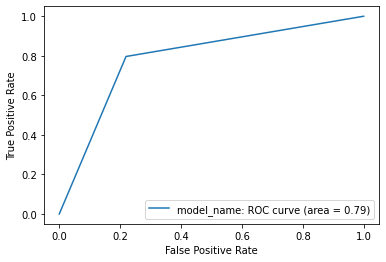

In [0]:
#x=df3.OFFRNARR.values
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
#cv = TfidfVectorizer(max_features=300)
#X = cv.fit_transform(x_train_text)

cv = TfidfVectorizer(max_features=5000)    
X = cv.fit_transform(x_train_text)
tx=cv.transform(x_test_text)
d=cv.transform(x_train_text).toarray()
x_train, x_test, y_train, y_test= X.toarray(),tx.toarray(),y_train_text,y_test_text
#print(x_train[0], d[0])
clf =LogisticRegression().fit(x_train, y_train)
#pred = cross_val_predict(clf, x_test, y_test, cv=3, n_jobs=4)  
pr=clf.predict(x_test)
#pr=[i[1]for i in pr]
results=confusion_matrix(y_test, clf.predict(x_test))          
print(roc_auc_score(y_test, pr))
plot_roc(clf,'model_name', y_test,pr)
#skplt.metrics.plot_roc_curve(y_test,pr)
#plt.show()

In [0]:
m={'a':1,'b':2,'c':3,'d':4,'e':5}
n=max(m.values())
for j,i in m.items():
  if i>2 and i<max(m.values()):
    print(i)

3
4
